<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/GridLSTM_PEMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-2024_0600.csv  
  inflating: m

In [ ]:

import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

try:
    # This block is for context and to make the script runnable.
    # It assumes 'combined_df' exists from the previous step.
    file_paths = glob('/content/my_pems_data/*.csv')
    all_data = []
    for file in file_paths:
        df_temp = pd.read_csv(file, delimiter='\t')
        df_temp.columns = df_temp.columns.str.strip()
        all_data.append(df_temp[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
    combined_df = pd.concat(all_data, ignore_index=True)
    processed_df = combined_df.rename(columns={'Flow (Veh/5 Minutes)': 'total_flow', 'Truck Flow (Veh/5 Minutes)': 'truck_flow'})
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']
    processed_df.loc[processed_df['non_truck_flow'] < 0, 'non_truck_flow'] = 0
    data_unscaled = np.concatenate([
        processed_df['truck_flow'].values.reshape(-1, 1),
        processed_df['non_truck_flow'].values.reshape(-1, 1)
    ], axis=1)
    scaler = MinMaxScaler((0, 1))
    data = scaler.fit_transform(data_unscaled)
    print("Initial data loaded and scaled successfully.")
except Exception as e:
    print(f"Could not run placeholder data loading. Assuming 'data' and 'scaler' exist. Error: {e}")


# --- START: YOUR DATA PREPARATION CODE ---
samples_per_day = 288
recent_days = 30
recent_rows = samples_per_day * recent_days  # 288 * 30 = 8640

historic_data = data[:-recent_rows]  # first ~49 days
recent_data = data[-recent_rows:]    # last 30 days

print(f"Historic data shape: {historic_data.shape}")
print(f"Recent data shape: {recent_data.shape}")

def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 15
X_hist, Y_hist = create_dataset(historic_data, time_step)
X_recent, Y_recent = create_dataset(recent_data, time_step)

print("\n--- After Creating Sequences ---")
print("Historic X shape:", X_hist.shape)
print("Historic Y shape:", Y_hist.shape)
print("Recent X shape:", X_recent.shape)
print("Recent Y shape:", X_recent.shape)

X_train_his = X_hist[:int(0.8*len(X_hist))]
y_train_his = Y_hist[:int(0.8*len(Y_hist))]
X_test_his = X_hist[int(0.8*len(X_hist)):]
y_test_his = Y_hist[int(0.8*len(Y_hist)):]

X_train_rec = X_recent[:int(0.8*len(X_recent))]
y_train_rec = Y_recent[:int(0.8*len(Y_recent))]
X_test_rec = X_recent[int(0.8*len(X_recent)):]
y_test_rec = Y_recent[int(0.8*len(Y_recent)):]


# --- Align sample sizes for model input ---
print("\n--- Aligning Data for Model Input ---")
min_train_len = min(len(X_train_his), len(X_train_rec))
min_test_len = min(len(X_test_his), len(X_test_rec))

X_train_his_aligned = X_train_his[-min_train_len:]
X_train_rec_aligned = X_train_rec[:min_train_len]
y_train_aligned = y_train_rec[:min_train_len] # Target is based on the recent data

X_test_his_aligned = X_test_his[-min_test_len:]
X_test_rec_aligned = X_test_rec[:min_test_len]
y_test_aligned = y_test_rec[:min_test_len] # Target is based on the recent data

print(f"Aligned Historic Train X shape: {X_train_his_aligned.shape}")
print(f"Aligned Recent Train X shape: {X_train_rec_aligned.shape}")
print(f"Aligned Train Y shape: {y_train_aligned.shape}")
print(f"Aligned Historic Test X shape: {X_test_his_aligned.shape}")
print(f"Aligned Recent Test X shape: {X_test_rec_aligned.shape}")
print(f"Aligned Test Y shape: {y_test_aligned.shape}")


from tensorflow.keras.layers import Conv1D, Multiply, Add, TimeDistributed

def build_conv_lstm_model(time_step, n_features):
    input0 = Input(shape=(time_step, n_features), name='historical_input')  #  (15, 2)
    input2 = Input(shape=(time_step, n_features), name='recent_input')      #  (15, 2)
# historical input(check this part)
    lstm_outputs = []
    for i in range(n_features):
        single_channel = input0[:, :, i:i+1]
        conv_layer = Conv1D(filters=32, kernel_size=3, activation='linear')(single_channel)
        lstm_layer = LSTM(64, return_sequences=True, dropout=0.2)(conv_layer)
        lstm_layer2 = LSTM(32, return_sequences=True, dropout=0.2)(lstm_layer)
        lstm_outputs.append(lstm_layer2)

    concatenated = Concatenate()(lstm_outputs)
    out_hist = LSTM(32, activation='relu', return_sequences=False,kernel_regularizer=regularizers.l2(0.1))(concatenated)

    # Recent input path
    dense = TimeDistributed(Dense(time_step, activation='relu'))(input2)
    out_recent = LSTM(32, activation='relu', return_sequences=False)(dense)


    combined = Concatenate()([out_hist, out_recent])
    output = Dense(n_features, activation='relu', name='final_output',kernel_regularizer=regularizers.l2(0.01))(combined)#(15,2)

    model = Model(inputs=[input0, input2], outputs=output, name='ConvLSTM-DualInput')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

n_features = X_train_his_aligned.shape[2]
model = build_conv_lstm_model(time_step=time_step, n_features=n_features)
model.summary()

print("\n--- Starting ConvLSTM-DualInput Model Training ---")
history = model.fit(
    [X_train_his_aligned, X_train_rec_aligned],
    y_train_aligned,
    epochs=50,
    validation_split=0.15,
    verbose=1
)




Initial data loaded and scaled successfully.
Historic data shape: (14184, 2)
Recent data shape: (8640, 2)

--- After Creating Sequences ---
Historic X shape: (14169, 15, 2)
Historic Y shape: (14169, 2)
Recent X shape: (8625, 15, 2)
Recent Y shape: (8625, 15, 2)

--- Aligning Data for Model Input ---
Aligned Historic Train X shape: (6900, 15, 2)
Aligned Recent Train X shape: (6900, 15, 2)
Aligned Train Y shape: (6900, 2)
Aligned Historic Test X shape: (1725, 15, 2)
Aligned Recent Test X shape: (1725, 15, 2)
Aligned Test Y shape: (1725, 2)


Model: "ConvLSTM-DualInput"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ historical_input    │ (None, 15, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 15, 1)     │          0 │ historical_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 15, 1)     │          0 │ historical_input… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 13, 32)    │        128 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 13, 32)    │        128 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 13, 64)    │     24,832 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 13, 64)    │     24,832 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 13, 32)    │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 13, 32)    │     12,416 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ recent_input        │ (None, 15, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13, 64)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 15, 15)    │         45 │ recent_input[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │      6,144 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 2)         │        130 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,487 (365.18 KB)

 Trainable params: 93,487 (365.18 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting ConvLSTM-DualInput Model Training ---
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 4.5639 - val_loss: 0.1728
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0803 - val_loss: 0.0047
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0022 - v

In [ ]:
model.save( 'gridlstm_model.keras')


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

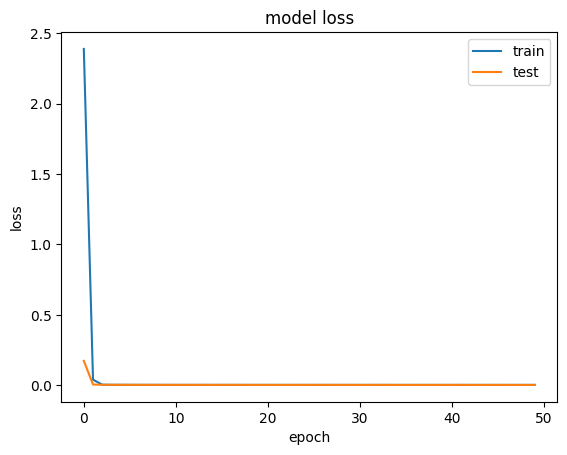

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=model.predict([X_test_his_aligned, X_test_rec_aligned])
test_predict=model.predict([X_test_his_aligned, X_test_rec_aligned])
# print(test_predict.shape)
predictions_original_scale = scaler.inverse_transform(test_predict)
y_test_original_scale = scaler.inverse_transform(y_test_aligned)
# mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
# mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))
# epsilon = 1e-10
# mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale+epsilon)
# rmse=np.sqrt(mse)
# print(rmse)
# print(mse)
# print(mae)
# print(mape)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


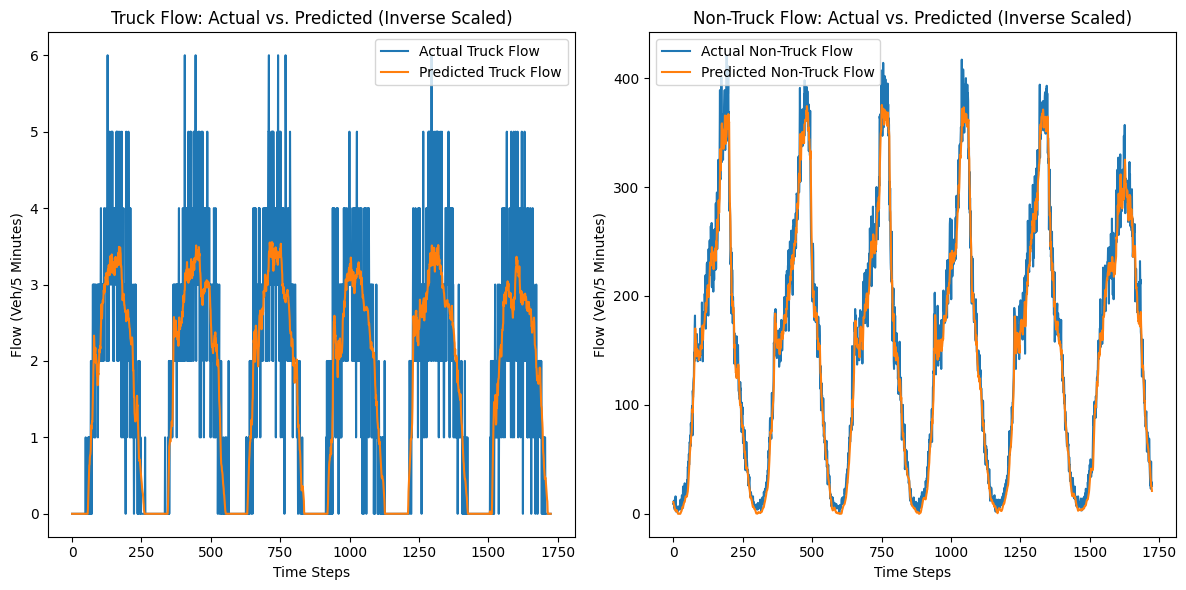

--- Metrics for Truck Flow (Original Scale) ---
RMSE: 0.8297
MAE: 0.5590
MAPE (masked): 37.08%

--- Metrics for Non-Truck Flow (Original Scale) ---
RMSE: 18.2138
MAE: 13.5407
MAPE (masked): 18.26%


In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))

# #  Truck Flow
# plt.subplot(1, 2, 1)
# plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
# plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
# plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# # Non-Truck Flow
# plt.subplot(1, 2, 2)
# plt.plot(y_test_original_scale[:, 1] , label='Actual Non-Truck Flow')
# plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
# plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 1], label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Truck Flow ---
actual_truck_flow = y_test_original_scale[:, 0]
predicted_truck_flow = predictions_original_scale[:, 0]

rmse_truck = np.sqrt(mean_squared_error(actual_truck_flow, predicted_truck_flow))
mae_truck = mean_absolute_error(actual_truck_flow, predicted_truck_flow)

# Masked MAPE
mask_truck = actual_truck_flow != 0
mape_truck = np.mean(
    np.abs((actual_truck_flow[mask_truck] - predicted_truck_flow[mask_truck]) / actual_truck_flow[mask_truck])
) * 100

print(f"--- Metrics for Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_truck:.4f}")
print(f"MAE: {mae_truck:.4f}")
print(f"MAPE (masked): {mape_truck:.2f}%")

# --- Non-Truck Flow ---
actual_non_truck_flow = y_test_original_scale[:, 1]
predicted_non_truck_flow = predictions_original_scale[:, 1]

rmse_non_truck = np.sqrt(mean_squared_error(actual_non_truck_flow, predicted_non_truck_flow))
mae_non_truck = mean_absolute_error(actual_non_truck_flow, predicted_non_truck_flow)

# Masked MAPE
mask_non_truck = actual_non_truck_flow != 0
mape_non_truck = np.mean(
    np.abs((actual_non_truck_flow[mask_non_truck] - predicted_non_truck_flow[mask_non_truck]) / actual_non_truck_flow[mask_non_truck])
) * 100

print(f"\n--- Metrics for Non-Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_non_truck:.4f}")
print(f"MAE: {mae_non_truck:.4f}")
print(f"MAPE (masked): {mape_non_truck:.2f}%")

In [ ]:
# import tensorflow as tf

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False
# tflite_model = converter.convert()

# # Save to .tflite file
# with open('gridlstm_model_quant.tflite', 'wb') as f:
#     f.write(tflite_model)

In [ ]:
# from google.colab import files

# # Download the quantized model
# files.download("gridlstm_model_quant.tflite")